## Night temperature determines nearly half of wheat yield variation globally

Authors: 
-    **Urs Christoph Schulthess** (CIMMYT - Izmir, Türkiye)
-    **Matthew Paul Reynolds** (CIMMYT - Texcoco, Mexico)
-    **Owen Kenneth Atkin** (Australian National University, Canberra, Australia)
-    **Ernesto Giron Echeverry** (Independent Researcher / Consultant, Cali - Colombia)
-    **Senthold Asseng** (Technische Universität München, Munich, Germany)
-    **Sieglinde Snapp** (CIMMYT)


Last update: Dec 18, 2025

### Acknowledgements 
We gratefully acknowledge support of Digital Transformation and the Climate Action Science Programs of CGIAR, and the International Wheat Yield Partnership [IWYP](https://iwyp.org/) funded by the Biotechnology and Biological Research Council of the UK.


## **Introduction**

This notebook contains algorithms and supporting code for investigating the response of wheat to warming nighttime temperatures.

Work through the cells below, running each cell in turn to replicate the results published in the paper.  

Contact us at e.giron.e@gmail.com if you find any mistakes or have any suggestions.

## Load libraries

In [1]:
from __future__ import absolute_import, division, print_function

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import os
import datetime as dt
import pandas as pd
import numpy as np
from nighttime_scripts import *

pd.set_option('display.max_columns', 200)

%matplotlib inline

## Load data

### Phenology and Weather data

Our data set consists of 850 site-years derived from the Elite Spring Wheat Yield Trials (ESWYT). It spans a period of 42 years and represents most of the important spring wheat growing areas on Earth.

Using [iPAR Yield model](https://github.com/egiron/IWIN), we fill gaps of the phenology espacially for days to maturity that was reported for 32% of the observations. 

Additional Python libraries were developed by our team in order to extract the daily weather parameters from [AgERA5](https://doi.org/10.24381/cds.6c68c9bb) and calculate weather related parameters for the following three periods: 

1) sowing to heading minus 10 days,
2) heading minus 10 days to heading plus 10 days, and
3) heading plus 10 days to maturity.

For each period, we calculated average daily minimum and maximum temperature, solar radiation, vapor pressure deficit (VPD), number of days on which daily maximum temperature is exceeding 30ºC and daily minimum temperature is exceeding 25ºC, and vapor pressure deficit VPD exceeding 4 kPa.

Part of the statistical analyses were conducted with the comercial software ([JMP 4.18](https://www.jmp.com) ), we use the Predictor Screening Platform and Neural Network platform to model the response and interactions between average daily minimum temperature and solar radiation during the grainfilling (_heading plus 10 days to maturity_) period. The output of this can be seen in the following table column named "_Predicted BLUE_YLD_t_ha TMinSRH10dM_"


The results of all the above processing can be loaded in the following cells:


In [2]:
%%time

# Load curated IWIN (ESWYT) dataset for paper
df_ESWYT = loadPheno_dataset()
df_ESWYT

CPU times: user 37.3 ms, sys: 14.2 ms, total: 51.5 ms
Wall time: 50.6 ms


Loc_no                             Loc_desc       Country     Lat  \
0     10001                       HOUTHAALDOORNS  SOUTH AFRICA -26.167   
1     10001                       HOUTHAALDOORNS  SOUTH AFRICA -26.167   
2     10001                       HOUTHAALDOORNS  SOUTH AFRICA -26.167   
3     10001                       HOUTHAALDOORNS  SOUTH AFRICA -26.167   
4     10002                SMALL GRAIN INSTITUTE  SOUTH AFRICA -28.163   
..      ...                                  ...           ...     ...   
845   65423                            GIMENELLS         SPAIN  41.583   
846   65423                            GIMENELLS         SPAIN  41.583   
847   65424  CENTRO DE INV. Y DESARROLLO AGRARIO         SPAIN  37.350   
848   65434                   TORREGROSSA/BELLOC         SPAIN  41.583   
849   65435                      CIDA-LAS TORRES         SPAIN  37.517   

       Long  Occ  Trial name Nursery  Nursery_Yr  HarvestYr  CycleStartYr  \
0    26.167    4  14TH ESWYT   ESWYT          14       1993          1992   
1    26.167   32  12TH ESWYT   ESWYT          12       1991          1990   
2    26.167   32  16TH ESWYT   ESWYT          16       1996          1995   
3    26.167   48  15TH ESWYT   ESWYT          15       1995          1994   
4    28.303   69  19TH ESWYT   ESWYT          19       1999          1998   
..      ...  ...         ...     ...         ...        ...           ...   
845   0.533   31  22ND ESWYT   ESWYT          22       2002          2001   
846   0.533   97  26TH ESWYT   ESWYT          26       2006          2005   
847  -3.583   25   9TH ESWYT   ESWYT           9       1988          1987   
848   0.750   13  39TH ESWYT   ESWYT          39       2019          2018   
849  -5.967   10  12TH ESWYT   ESWYT          12       1991          1990   

     Cycle  Days_TO_HEAD_QC  DAYS_TO_MATURITY_QC  BLUE_YLD_t_ha sowing_Date  \
0    92-93              NaN                  NaN       6.163100  1992-06-20   
1    90-91              NaN                  NaN       5.771967  1990-06-03   
2    95-96              NaN                  NaN       8.009300  1995-06-22   
3    94-95              NaN                  NaN       9.920960  1994-06-20   
4    98-99          77.7400                  NaN       7.026660  1998-08-06   
..     ...              ...                  ...            ...         ...   
845   2001         140.8400                  NaN       7.935020  2001-12-01   
846   2005         160.1600                  NaN       6.104360  2005-11-22   
847  87-88         142.2778             182.5890       8.885533  1987-12-10   
848   2018         134.3400                  NaN      10.063840  2018-12-07   
849  90-91         111.6556             161.4167       7.605700  1990-12-21   

    heading_Date maturity_Date  Days_To_Heading_fgaps  Days_To_Maturity_fgaps  \
0     1992-09-07    1992-10-18                79.0000                120.0000   
1     1990-08-30    1990-10-14                88.0000                133.0000   
2     1995-09-09    1995-10-20                79.0000                120.0000   
3     1994-09-08    1994-10-23                80.0000                125.0000   
4     1998-10-22    1998-12-09                77.5200                125.3800   
..           ...           ...                    ...                     ...   
845   2002-04-20    2002-06-03               140.1000                184.3600   
846   2006-04-30    2006-06-06               159.7600                196.8000   
847   1988-04-30    1988-06-09               142.1333                182.2667   
848   2019-04-19    2019-06-03               133.8800                178.6000   
849   1991-04-11    1991-05-31               111.3667                161.1333   

     avg_TMax_season_ºC  avg_TMin_season_ºC  avg_VPD_season_kPa  \
0                 21.50                7.20                0.93   
1                 20.90                6.70                0.89   
2                 22.40                7.70                1.01   
3

#### Variable explanations

If you want to know more about the variables used in this study, you can do it as follows:

In [3]:
loadVariablesDescription()

Variable names  \
0                                Loc_no   
1                              Loc_desc   
2                               Country   
3                                   Lat   
4                                  Long   
5                                   Occ   
6                            Trial name   
7                               Nursery   
8                            Nursery_Yr   
9                             HarvestYr   
10                         CycleStartYr   
11                                Cycle   
12                      Days_TO_HEAD_QC   
13                  DAYS_TO_MATURITY_QC   
14                        BLUE_YLD_t/ha   
15                          sowing_Date   
16                         heading_Date   
17                        maturity_Date   
18                Days_To_Heading_fgaps   
19               Days_To_Maturity_fgaps   
20                   avg_TMax_season_ºC   
21                   avg_TMin_season_ºC   
22                   avg_VPD_season_kPa   
23              ndays_VPD_gt4kPa_season   
24              ndays_TMax_gt32C_season   
25              ndays_TMin_gt25C_season   
26                  avg_TMax_SHminus10d   
27                  avg_TMin_SHminus10d   
28                   avg_VPD_SHminus10d   
29          ndays_VPD_gt4kPa_SHminus10d   
30          ndays_TMax_gt32C_SHminus10d   
31          ndays_TMin_gt25C_SHminus10d   
32          avg_TMax_Hminus10d-Hplus10d   
33          avg_TMin_Hminus10d-Hplus10d   
34           avg_VPD_Hminus10d-Hplus10d   
35  ndays_VPD_gt4kPa_Hminus10d-Hplus10d   
36  ndays_TMax_gt32C_Hminus10d-Hplus10d   
37  ndays_TMin_gt25C_Hminus10d-Hplus10d   
38                   avg_TMax_GrainFill   
39                   avg_TMin_GrainFill   
40                    avg_VPD_GrainFill   
41           ndays_VPD_gt4kPa_GrainFill   
42           ndays_TMax_gt32C_GrainFill   
43           ndays_TMin_gt25C_GrainFill   
44                          Days_HM_Obs   
45                       Days_GFill_Obs   

                                          Explanation  \
0                             Number of the location    
1                         Description of the location   
2   Name of country (official names may have changed)   
3                                            Latitude   
4                                           Longitude   
5   Occurence (occasionally, the same nursery was ...   
6                  Number of nursery and nursery name   
7                         Name of the nursery (ESWYT)   
8              Number of nursery year, e.g., 1,2,3…41   
9                                     Year of harvest   
10                  Year in which ESWYT cycle started   
11                                   # of ESWYT cycle   
12     Quality controlled days to heading from sowing   
13    Quality controlled days to maturity from sowing   
14  Best linear unbiased estimation (BLUE) yield (...   
15                           Sowing date (yyyy-mm-dd)   
16                          Heading date (yyyy-mm-dd)   
17                         Maturity date (yyyy-mm-dd)   
18                         Gap filled days to heading   
19                        Gap filled days to maturity   
20  avereage daily maximum temperature from sowing...   
21  avereage daily minimum temperature from sowing...   
22  avereage daily vapor pressure deficit from sow...   
23  Number of days with daily VPD greater than 4 k...   
24  Number of days on which daily maximum temperat...   
25  Number of days on which daily maximum temperat...   
26                                       Average TMax   
27                                       Average TMin   
28                                        Average VPD   
29            Number of days with VPD exceeding 4 kPa   
30            Number of days with TMax exceeding 32ºC   
31            Number of days with TMin exceeding 25ºC   
32                                       Average TMax   
33                                       Average TMin   
34      

### Dataset for Figures

To reproduce the figures published in the paper, we will create a subset of the above data for easy manipulation. Just the same number of observations (850 records) and small number of columns with the important variables from the analysis.

In [4]:
%%time

# Load data for figures
gdf_for_Fig1 = loadFigures_dataset(df_ESWYT)


CPU times: user 73.9 ms, sys: 2.74 ms, total: 76.6 ms
Wall time: 75.6 ms


## Figures for paper:

All analysis code to reproduce the reported results and figures from the shared data, 
as well as a notebook that explains the methods

### Fig. 1

We used a data set derived from the Elite Spring Wheat Yield Trials (ESWYT) nurseries grown between 1979 and 2021 for this analysis. Under the umbrella of the International Wheat Improvement Network (IWIN), CIMMYT sends out different nurseries consisting of 30 to 50 advanced lines for testing by its partners across all the major wheat production regions on Earth.

All of the maps below were initially created in [QGIS](https://qgis.org) geographic information system software that is free and open-source. Then we exported the classification legends in [SLD format](https://en.wikipedia.org/wiki/Styled_Layer_Descriptor) to be used in the following figures. This helps us to preserved the colors and ranges synced with the map and histograms.


#### Fig 1a. Map of Grain yield distribution during grainfilling

CPU times: user 2.49 s, sys: 192 ms, total: 2.68 s
Wall time: 2.47 s


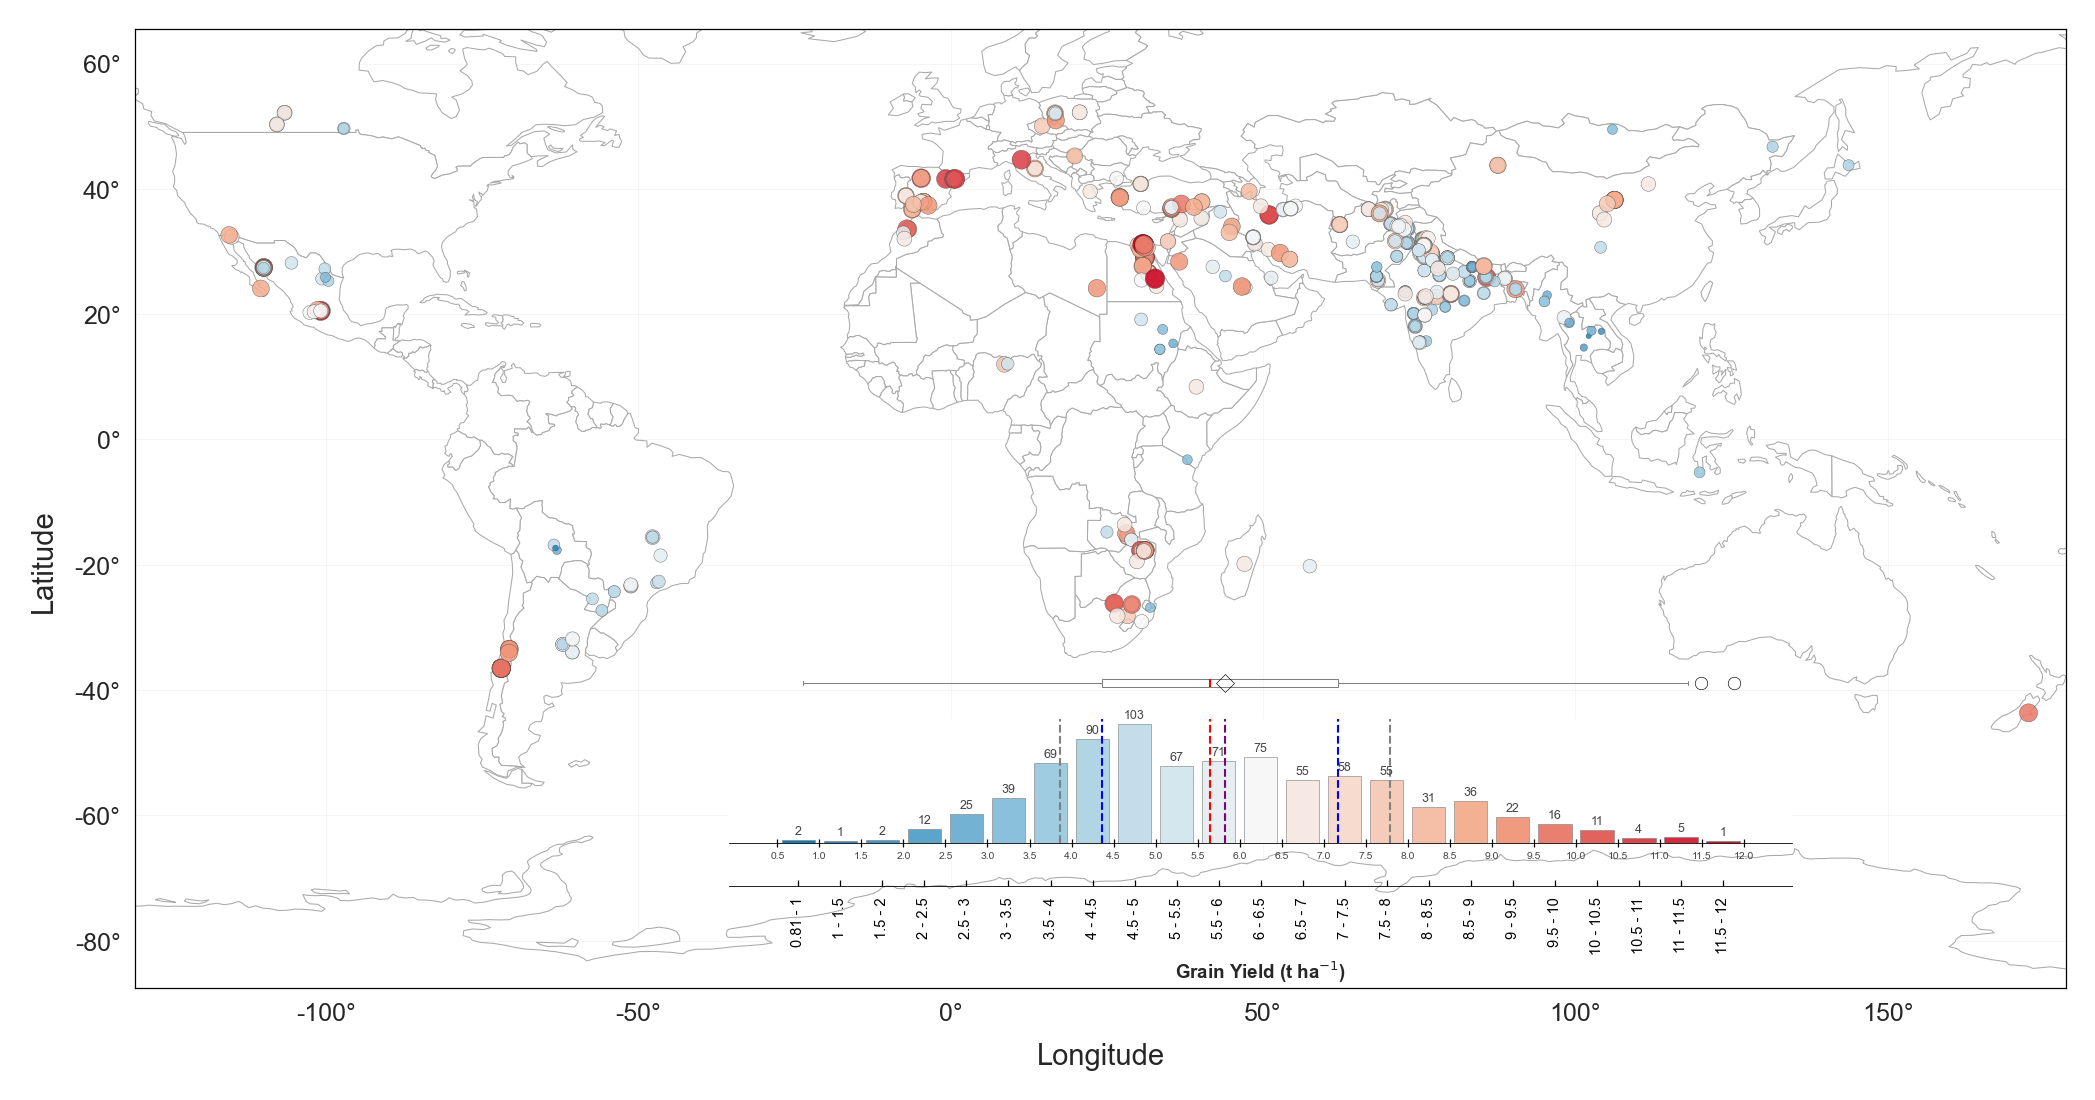

In [5]:
%%time

# Display Map with horizontal legend
dispGrainYieldMap(gdf_for_Fig1)


#### Fig 1b. Map of Solar Radition during grainfilling

CPU times: user 723 ms, sys: 65.7 ms, total: 788 ms
Wall time: 409 ms


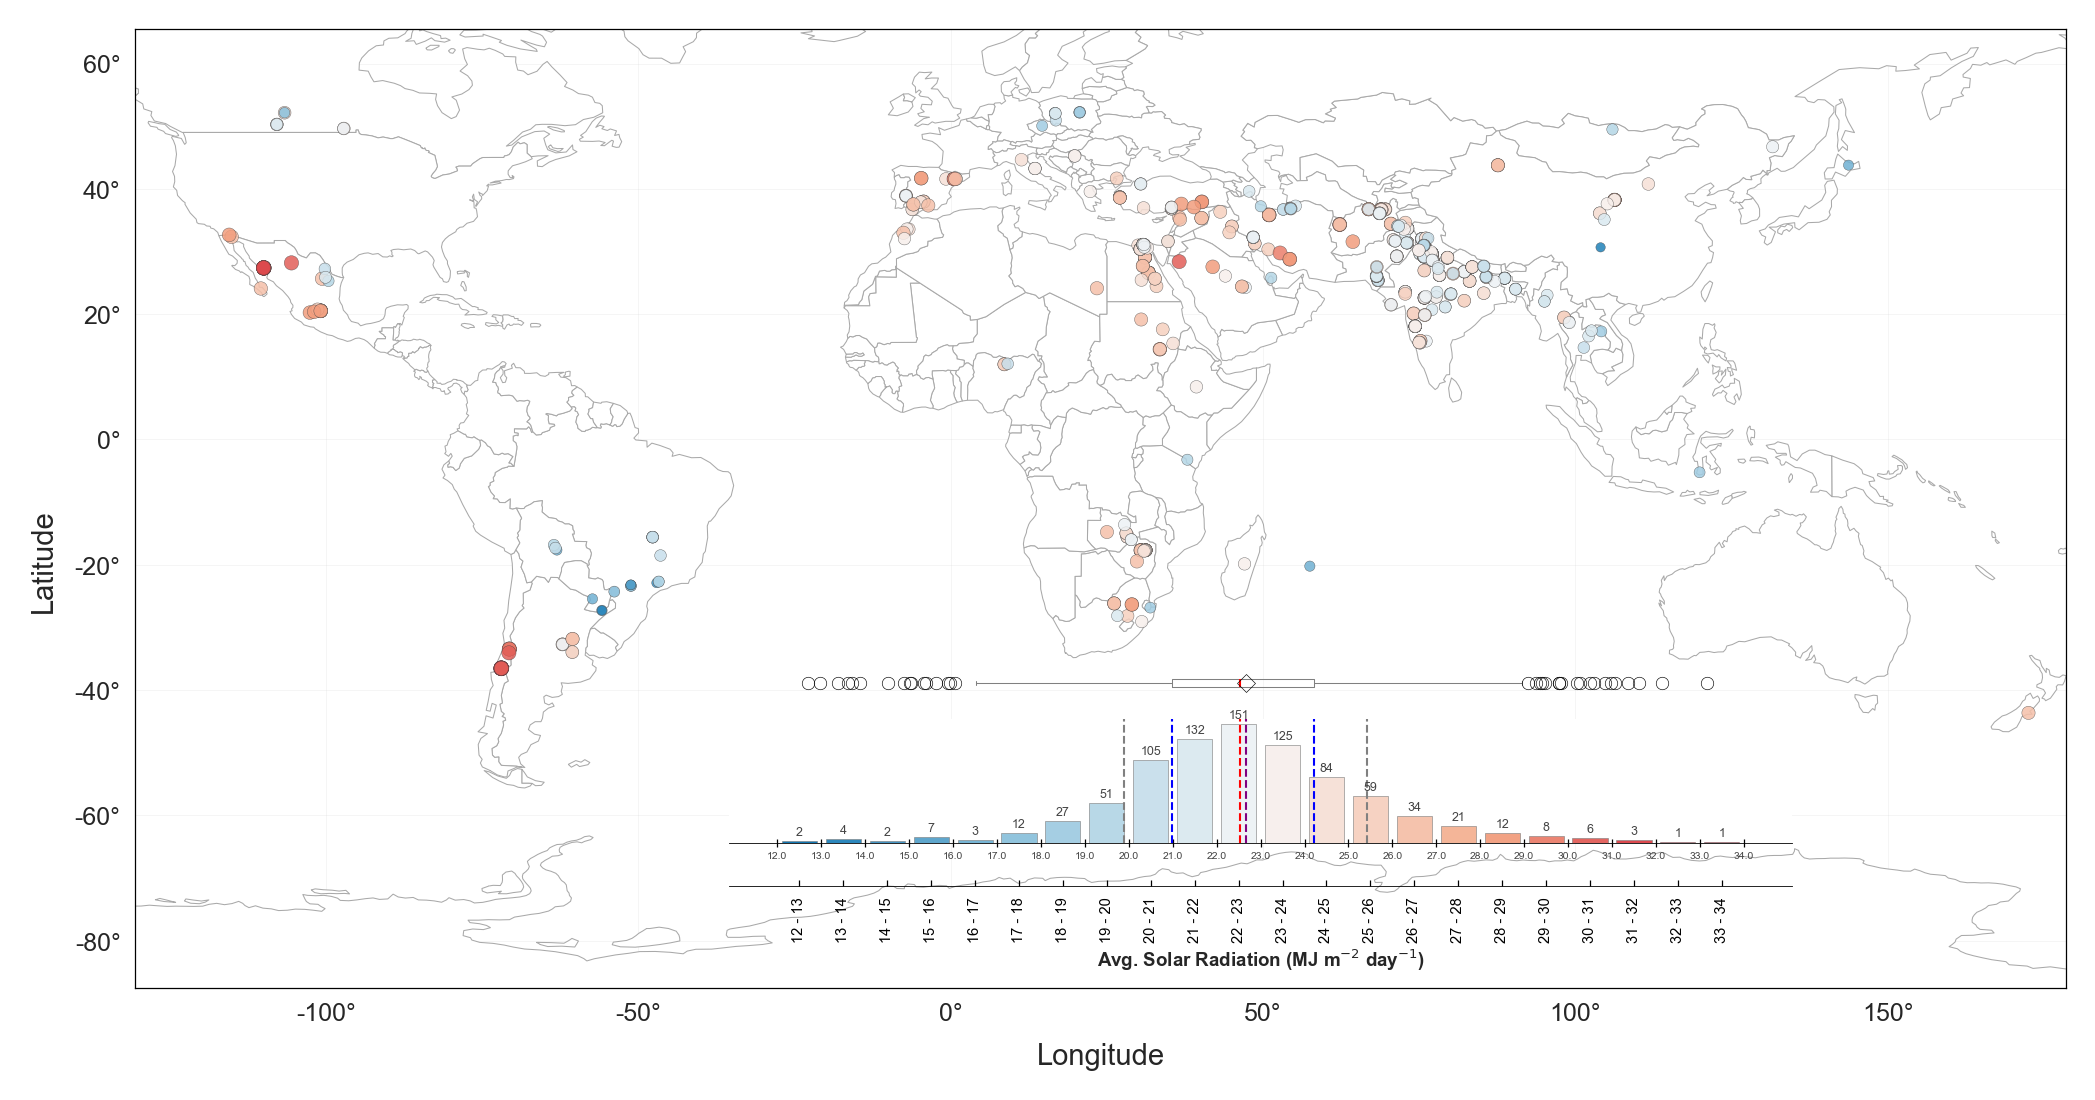

In [6]:
%%time

dispSolRadMap(gdf_for_Fig1)

#### Fig 1c. Map of Avg. Maximum Temperature (ºC) during grainfilling

CPU times: user 719 ms, sys: 66.6 ms, total: 786 ms
Wall time: 406 ms


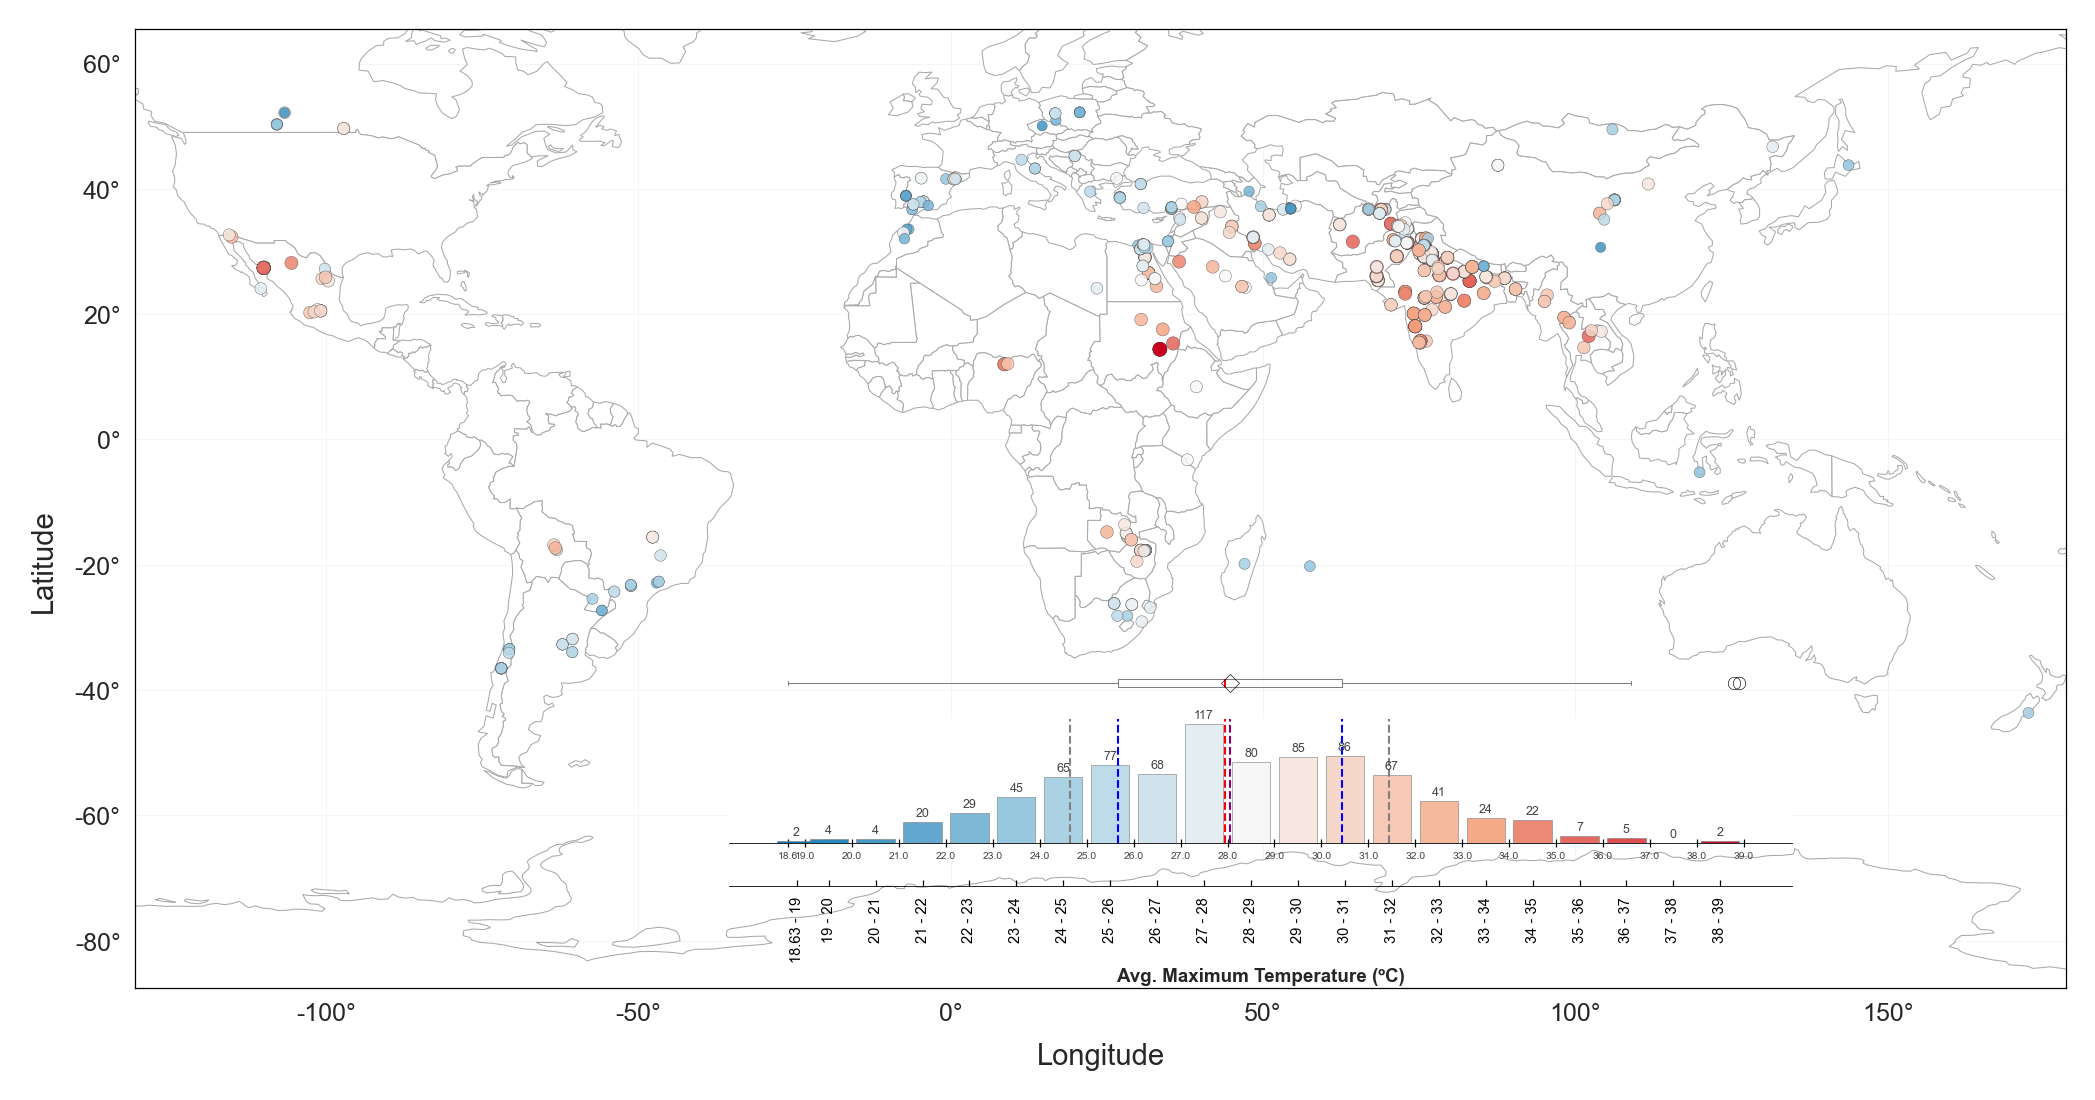

In [7]:
%%time

dispAvgMaxTemperatureMap(gdf_for_Fig1)

#### Fig 1d. Map of Avg. Minimum Temperature (ºC) during grainfilling

CPU times: user 816 ms, sys: 72.4 ms, total: 888 ms
Wall time: 507 ms


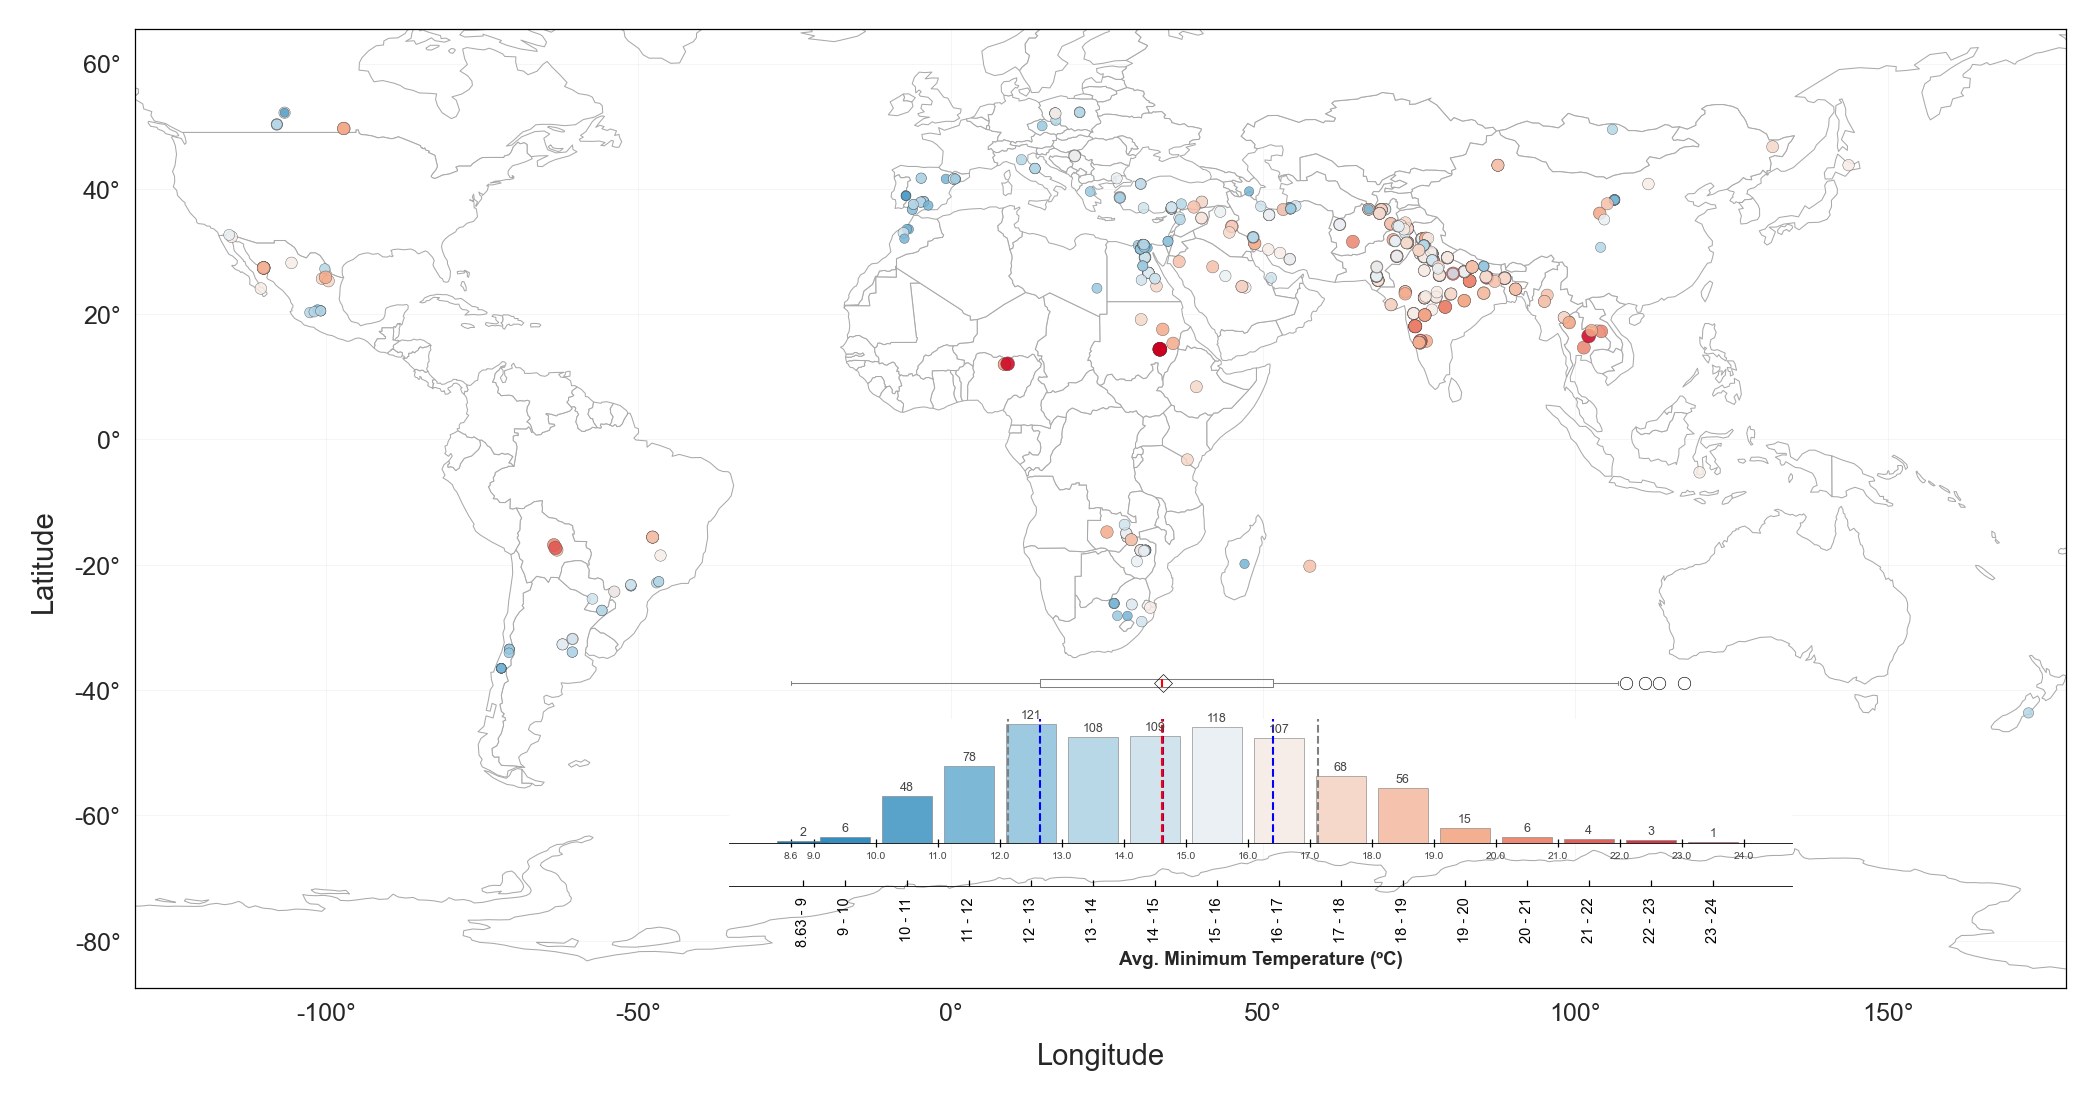

In [8]:
%%time

dispAvgMinTemperatureMap(gdf_for_Fig1)

### Fig. 2

Effect of average minimum temperatures and solar radiation during the grain filling period on the average yield obtained at 850 nursery-site-years. The non-significant interaction effects of different levels of solar radiation (SR) are overlaid.



CPU times: user 20.5 s, sys: 116 ms, total: 20.6 s
Wall time: 20.2 s


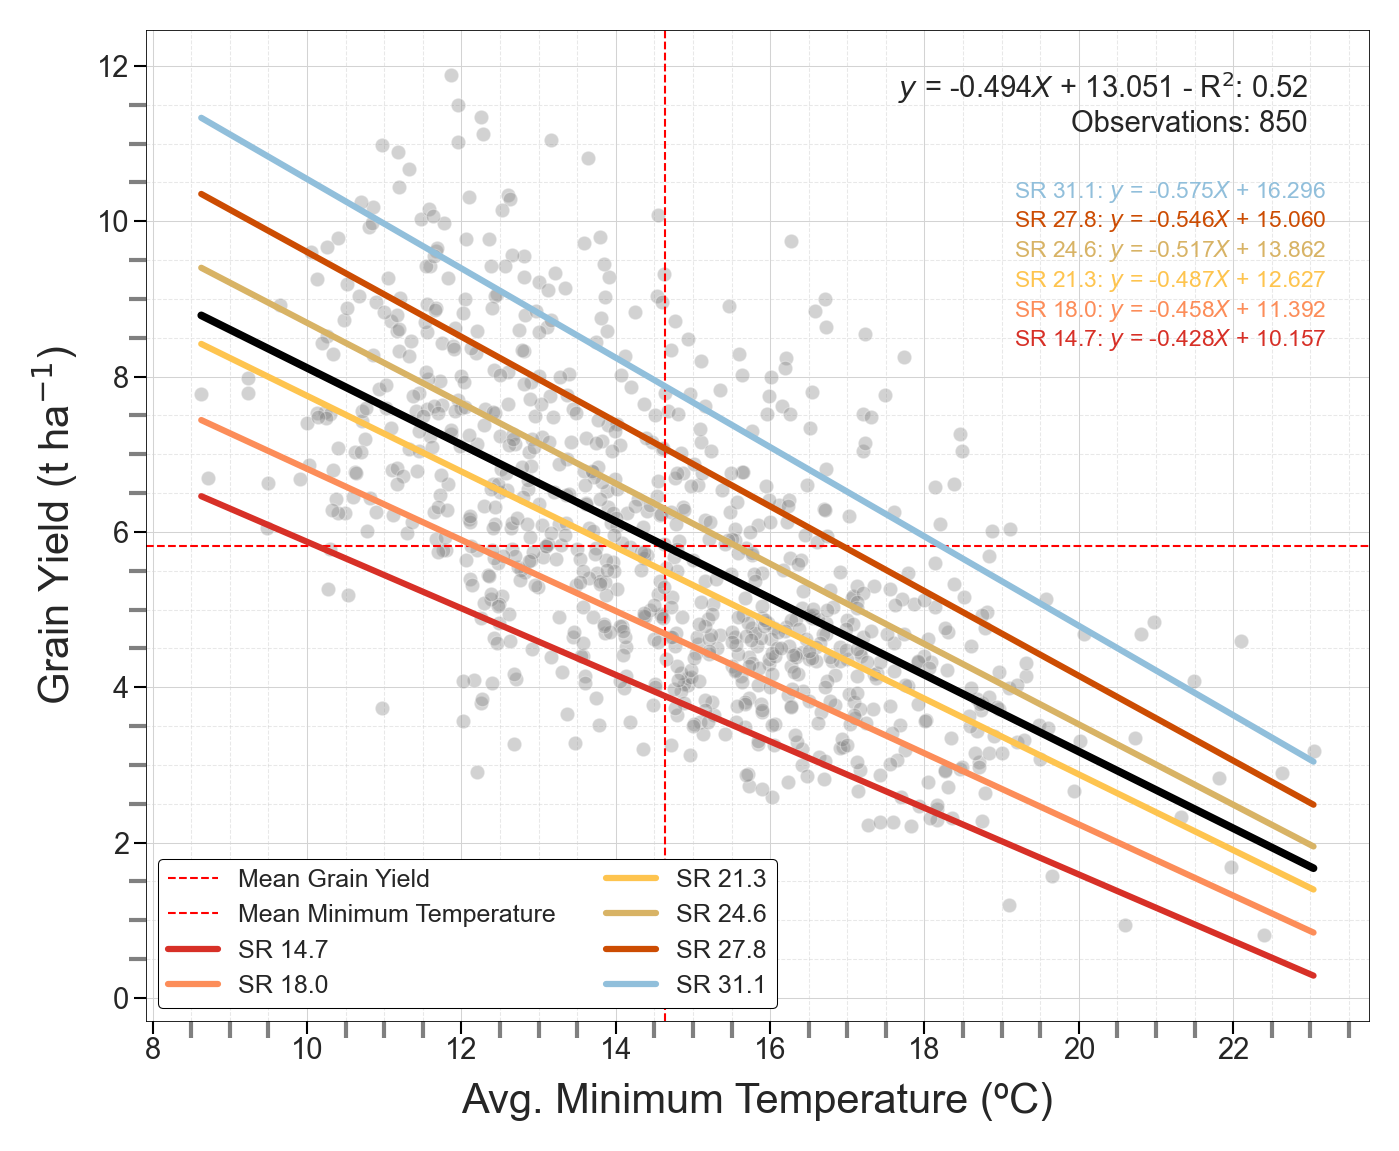

In [10]:
%%time

dispFig2_SolRad_avgTmin(gdf_for_Fig1)


Combined minimum temperature and solar radiation during grain filling can explain 52% of the variability of grain yield at sites across the globe, with a root mean square error of 1.38 t/ha.

**Our data set which encompasses the majority of spring wheat production regions, shows that the yield response to average nighttime temperature is linear within the observed range from 8ºC to 22ºC. An increase of 1ºC of average nighttime temperature reduces yield by 0.5 t/ha.**

### Yield loss and TMin Change calculations

In order to quantify and visualize the changes in minimum daily temperatures during the grainfilling period, we calculated the average minimum temperature for each site-year-occurrence combination, between the start and end day of the year for all 42 years. 

#### Load Weather stats of 42 years by site-occ-year

In [11]:
%%time

df_pw40Yrs = loadPhenoWeather40yrs_dataset()
df_pw40Yrs

CPU times: user 28.5 ms, sys: 15.4 ms, total: 43.9 ms
Wall time: 16.9 ms


Loc_no         Loc_desc       Country     Lat    Long  Occ  Trial name  \
0       10001   HOUTHAALDOORNS  SOUTH AFRICA -26.167  26.167   32  12TH ESWYT   
1       10001   HOUTHAALDOORNS  SOUTH AFRICA -26.167  26.167   32  12TH ESWYT   
2       10001   HOUTHAALDOORNS  SOUTH AFRICA -26.167  26.167   32  12TH ESWYT   
3       10001   HOUTHAALDOORNS  SOUTH AFRICA -26.167  26.167   32  12TH ESWYT   
4       10001   HOUTHAALDOORNS  SOUTH AFRICA -26.167  26.167   32  12TH ESWYT   
...       ...              ...           ...     ...     ...  ...         ...   
45649   65435  CIDA-LAS TORRES         SPAIN  37.517  -5.967   10  12TH ESWYT   
45650   65435  CIDA-LAS TORRES         SPAIN  37.517  -5.967   10  12TH ESWYT   
45651   65435  CIDA-LAS TORRES         SPAIN  37.517  -5.967   10  12TH ESWYT   
45652   65435  CIDA-LAS TORRES         SPAIN  37.517  -5.967   10  12TH ESWYT   
45653   65435  CIDA-LAS TORRES         SPAIN  37.517  -5.967   10  12TH ESWYT   

      Nursery  Nursery_Yr  HarvestYr  CycleStartYr  Cycle  Days_TO_HEAD_QC  \
0       ESWYT          12       1979          1979  79-79               88   
1       ESWYT          12       1980          1980  80-80               88   
2       ESWYT          12       1981          1981  81-81               88   
3       ESWYT          12       1982          1982  82-82               88   
4       ESWYT          12       1983          1983  83-83               88   
...       ...         ...        ...           ...    ...              ...   
45649   ESWYT          12       2017          2016  17-16              111   
45650   ESWYT          12       2018          2017  18-17              111   
45651   ESWYT          12       2019          2018  19-18              111   
45652   ESWYT          12       2020          2019  20-19              111   
45653   ESWYT          12       2021          2020  21-20              111   

       DAYS_TO_MATURITY_QC sowing_Date heading_Date maturity_Date  \
0                      139  1979-06-03   1979-08-30    1979-10-20   
1                      139  1980-06-03   1980-08-30    1980-10-20   
2                      139  1981-06-03   1981-08-30    1981-10-20   
3                      139  1982-06-03   1982-08-30    1982-10-20   
4                      139  1983-06-03   1983-08-30    1983-10-20   
...                    ...         ...          ...           ...   
45649                  161  2016-12-21   2017-04-11    2017-05-31   
45650                  161  2017-12-21   2018-04-11    2018-05-31   
45651                  161  2018-12-21   2019-04-11    2019-05-31   
45652                  161  2019-12-21   2020-04-10    2020-05-30   
45653                  161  2020-12-21   2021-04-11    2021-05-31   

       avg_TMax_season  avg_TMin_season  avg_SolRad_season  \
0                19.94             6.46              17.97   
1                19.86             5.80              18.50   
2                18.99             4.84              18.16   
3                20.44             6.72              17.81   
4                20.42             6.26              18.35   
...                ...              ...                ...   
45649            21.62             9.61              16.75   
45650            19.14             8.36              15.63   
45651            22.20             9.27              17.59   
45652            21.59            10.27              15.81   
45653            20.80             9.54              16.30   

       avg_TMax_SHminus10d  avg_TMin_SHminus10d  avg_SolRad_SHminus10d  \
0                    17.07                 3.82                  15.06   
1                    17.21                 2.86                  15.96   
2                    17.52                 3.29                  15.65   
3                    17.96                 3.69                  15.39   
4                    17.75                 3.72                  15.21   
...                    ...                  ...                    ...   
45649

Next, we fit a linear regression of harvest year versus all average minimum temperatures to estimate the change in minimum temperatures during grain filling **at a given location**. 

In a last step, we used the finding of this study (_Fig S2 below_) that an increase in average minimum daily temperatures by 1ºC decreases yield by 0.5 t/ha to estimate the yield loss, using the average of the reported yields at a given location as a reference. 

#### Estimate Change in Tmin and Yield loss

In [12]:
%%time
df_ChangeInTmin_YieldLoss = estimateChangeInTmin_YieldLoss(df_pw40Yrs, df_ESWYT)
df_ChangeInTmin_YieldLoss

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 386.59it/s]

CPU times: user 1.44 s, sys: 170 ms, total: 1.61 s
Wall time: 697 ms


Loc_no                             Loc_desc       Country     Lat  \
0     10001                       HOUTHAALDOORNS  SOUTH AFRICA -26.167   
1     10002                SMALL GRAIN INSTITUTE  SOUTH AFRICA -28.163   
2     10025                              SANDVET  SOUTH AFRICA -28.133   
3     10026                               PANNAR  SOUTH AFRICA -26.333   
4     10029                        REDGATES FARM  SOUTH AFRICA -29.067   
..      ...                                  ...           ...     ...   
250   65422                   FINCA LA CARRERADA         SPAIN  41.583   
251   65423                            GIMENELLS         SPAIN  41.583   
252   65424  CENTRO DE INV. Y DESARROLLO AGRARIO         SPAIN  37.350   
253   65434                   TORREGROSSA/BELLOC         SPAIN  41.583   
254   65435                      CIDA-LAS TORRES         SPAIN  37.517   

       Long  SlopeTMinGFill       p_value  TMinChangeGFill  YldLossTon  \
0    26.167        0.034490  6.491023e-09         1.448597    0.715607   
1    28.303        0.026029  4.301013e-03         1.093239    0.540060   
2    26.683        0.024566  2.275843e-02         1.031775    0.509697   
3    29.000        0.030426  6.729884e-04         1.277907    0.631286   
4    30.583        0.015927  6.592218e-02         0.668951    0.330462   
..      ...             ...           ...              ...         ...   
250  -0.750        0.048441  9.606142e-05         2.034521    1.005053   
251   0.533        0.056332  6.794565e-13         2.365957    1.168783   
252  -3.583        0.047455  3.444024e-03         1.993103    0.984593   
253   0.750        0.052374  2.148889e-04         2.199716    1.086660   
254  -5.967        0.057636  3.898585e-05         2.420726    1.195839   

     avg_TMin_GrainFill  BLUE_YLD_t_ha  YldLossPc                    geometry  
0                11.925          7.466   9.584875  POINT (26.16700 -26.16700)  
1                10.620          7.027   7.685498  POINT (28.30300 -28.16300)  
2                11.100          6.798   7.497750  POINT (26.68300 -28.13300)  
3                11.822          6.612   9.547581  POINT (29.00000 -26.33300)  
4                13.290          5.829   5.669268  POINT (30.58300 -29.06700)  
..                  ...            ...        ...                         ...  
250              10.700         10.244   9.811140   POINT (-0.75000 41.58300)  
251              12.810          7.915  14.766683    POINT (0.53300 41.58300)  
252              10.520          8.886  11.080269   POINT (-3.58300 37.35000)  
253              11.630         10.064  10.797495    POINT (0.75000 41.58300)  
254              12.050          7.606  15.722307   POINT (-5.96700 37.51700)  

[255 rows x 13 columns]

### Table S1

Supplementary Table 1: Average change in minimum temperature (Tmin) during grain filling at the ESWYT nurseries test sites. Yield data represent the average nursery yield reported within a country, and yield losses are expressed as a percentage of the reported yield. The data cover 42 years, from 1979 until 2021.


In [13]:
%%time

loadTableS1(df_ChangeInTmin_YieldLoss)


CPU times: user 20.5 ms, sys: 5.11 ms, total: 25.6 ms
Wall time: 13.4 ms


Country  Change in TMin grain filling (℃)  Yield (t/ha)  \
0      Afghanistan                             1.811         5.611   
1        Argentina                             0.912         5.234   
2       Bangladesh                             0.545         4.715   
3          Bolivia                             1.154         2.412   
4           Brazil                             0.710         4.563   
5           Canada                             0.056         4.830   
6            Chile                             0.172         8.964   
7            China                             1.727         6.126   
8   Czech Republic                             2.764         7.294   
9            Egypt                             1.343         8.020   
10        Ethiopia                             1.139         6.298   
11          Greece                             2.134         6.133   
12           India                             0.929         4.855   
13       Indonesia                             0.280         3.398   
14            Iran                             1.430         6.599   
15            Iraq                             1.498         6.362   
16          Israel                             1.255         6.550   
17           Italy                             1.775         8.638   
18           Japan                             0.956         3.548   
19           Libya                             1.211         8.859   
20      Madagascar                             0.601         6.794   
21       Mauritius                             0.948         5.309   
22          Mexico                             1.040         5.828   
23        Mongolia                             1.203         2.907   
24         Morocco                             2.051         7.301   
25         Myanmar                             0.710         2.663   
26           Nepal                             0.615         5.278   
27     New Zealand                             0.525         9.422   
28         Nigeria                             0.859         5.158   
29        Pakistan                             1.524         4.713   
30        Paraguay                             0.729         3.890   
31          Poland                             2.456         6.486   
32        Portugal                             1.696         6.815   
33           Qatar                             1.785         5.321   
34    Saudi Arabia                             1.951         6.257   
35          Serbia                             1.928         6.497   
36    South Africa                             1.104         6.746   
37           Spain                             2.146         8.155   
38           Sudan                             2.461         3.172   
39       Swaziland                             0.476         2.726   
40           Syria                             2.131         6.263   
41        Tanzania                             0.358         2.823   
42        Thailand                             0.379         2.352   
43          Turkey                             1.526         7.118   
44          Zambia                             0.699         6.012   
45        Zimbabwe                             0.683         7.160   

    Yield loss (t/ha)  Yield loss (%)  
0               0.895          15.748  
1               0.451           8.678  
2               0.269           6.049  
3               0.570          45.355  
4               0.351           8.026  
5               0.028           0.619  
6               0.085           0.992  
7               0.853          14.460  
8               1.365          18.719  
9               0.663           8.608  
10              0.562           8.931  
11              1.054          17.191  
12              0.459           9.639  
13              0.138           4.074  
14              0.706          10.848  
15              0.740          13.184  
16              0.620           9.466  


Our nighttime-based model shows an alarming trend, with the potential yield generally declining by **12%** or more over the past four decades

### Fig 3. Change in Avg. Minimum Temperature (ºC) during grainfilling

Change in minimum temperature (ºC) at 255 nursery test sites of spring wheat between 1979 and 2021 during the grain filling period.


CPU times: user 708 ms, sys: 76.1 ms, total: 784 ms
Wall time: 353 ms


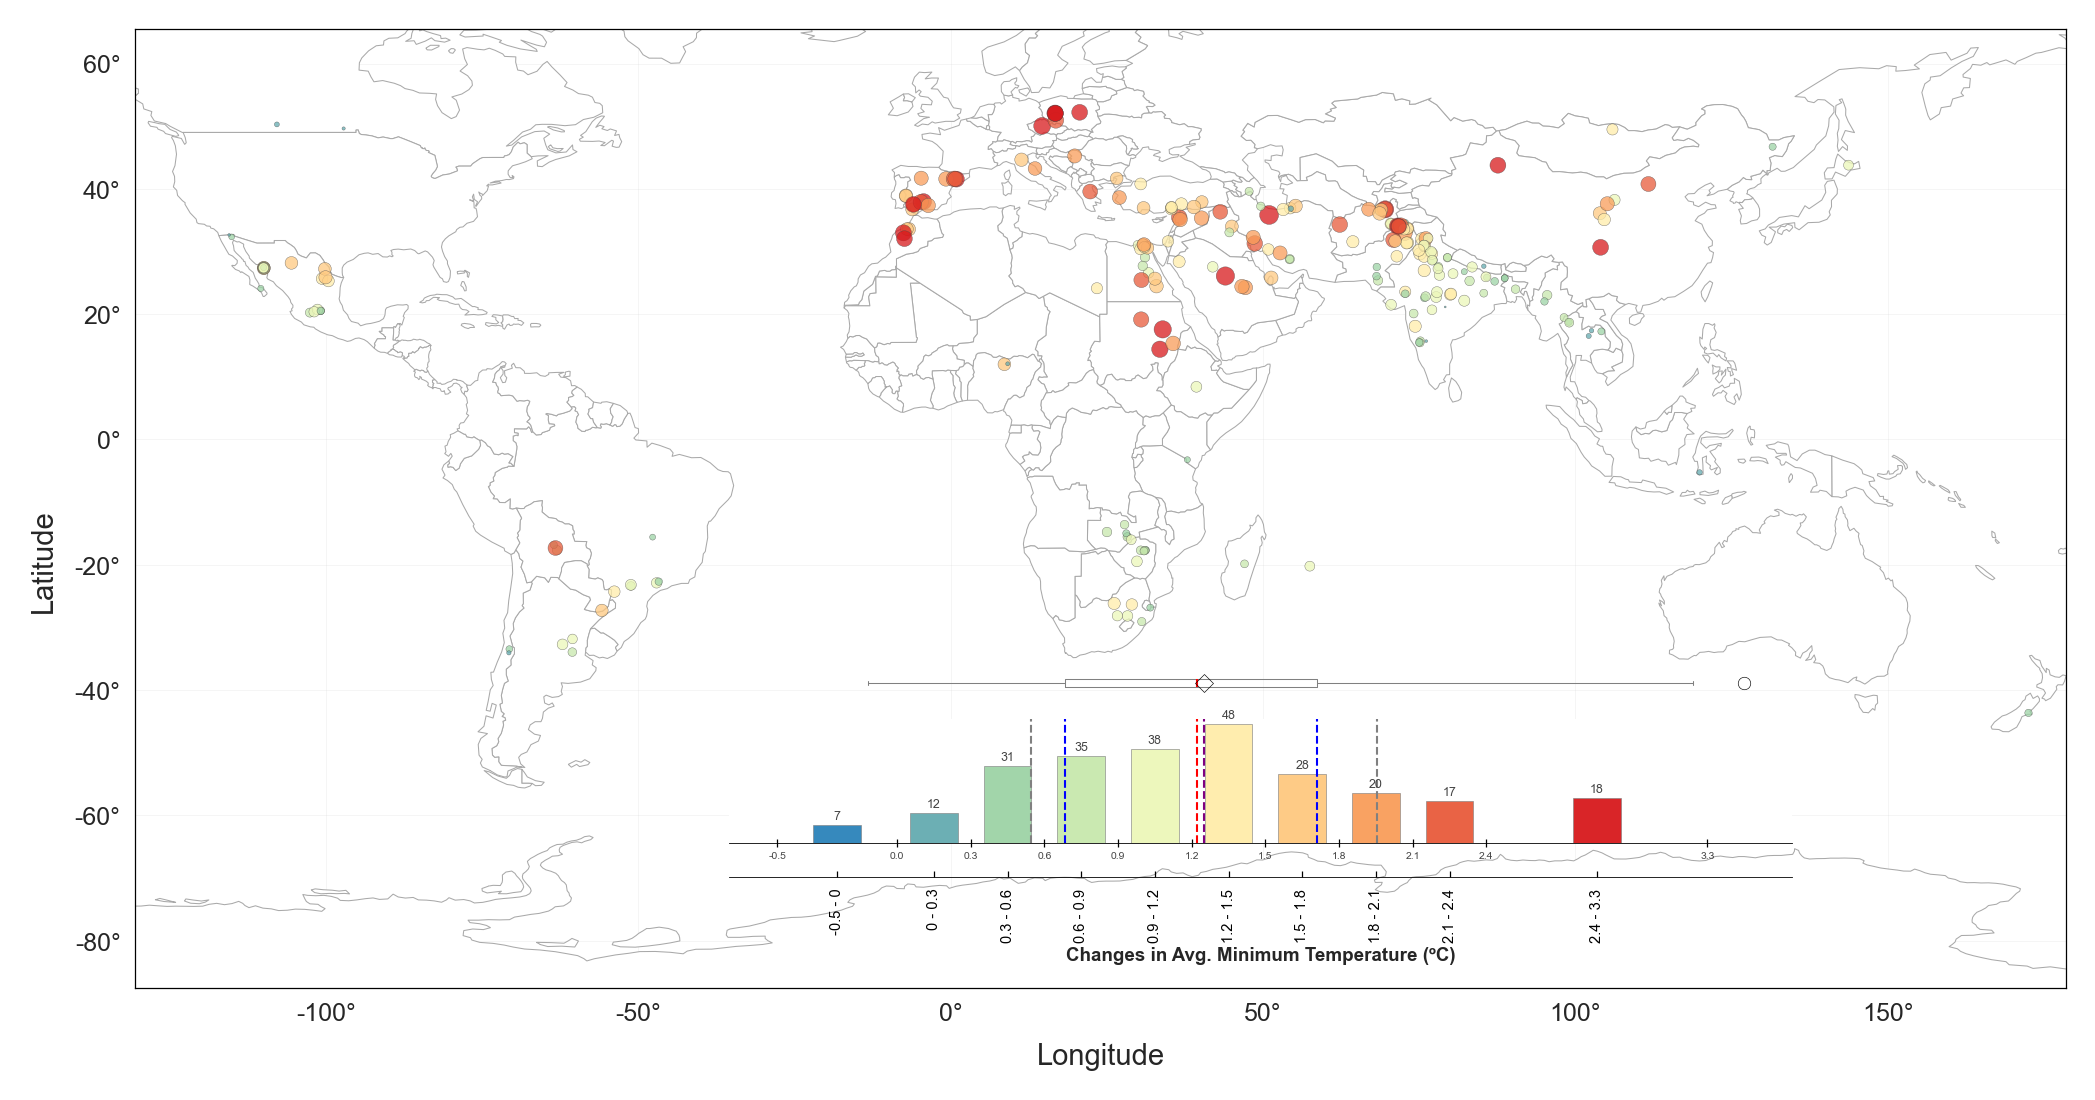

In [14]:
%%time

dispChangesInTMinMap(df_ChangeInTmin_YieldLoss)

There is a large regional variability in the increase in nighttime temperatures during grain filling over the period from 1980 to 2021. The largest increases were observed for the Mediterranean basin. They were generally **above 1.5ºC.**

Interestingly, in India and Pakistan, the warming trend was higher at sites in the Indo-Gangetic Plain than at those further south.

### Fig 4. Yield loss (%) due to increase in TMin (1980-2020) during grainfilling

CPU times: user 644 ms, sys: 58.2 ms, total: 703 ms
Wall time: 325 ms


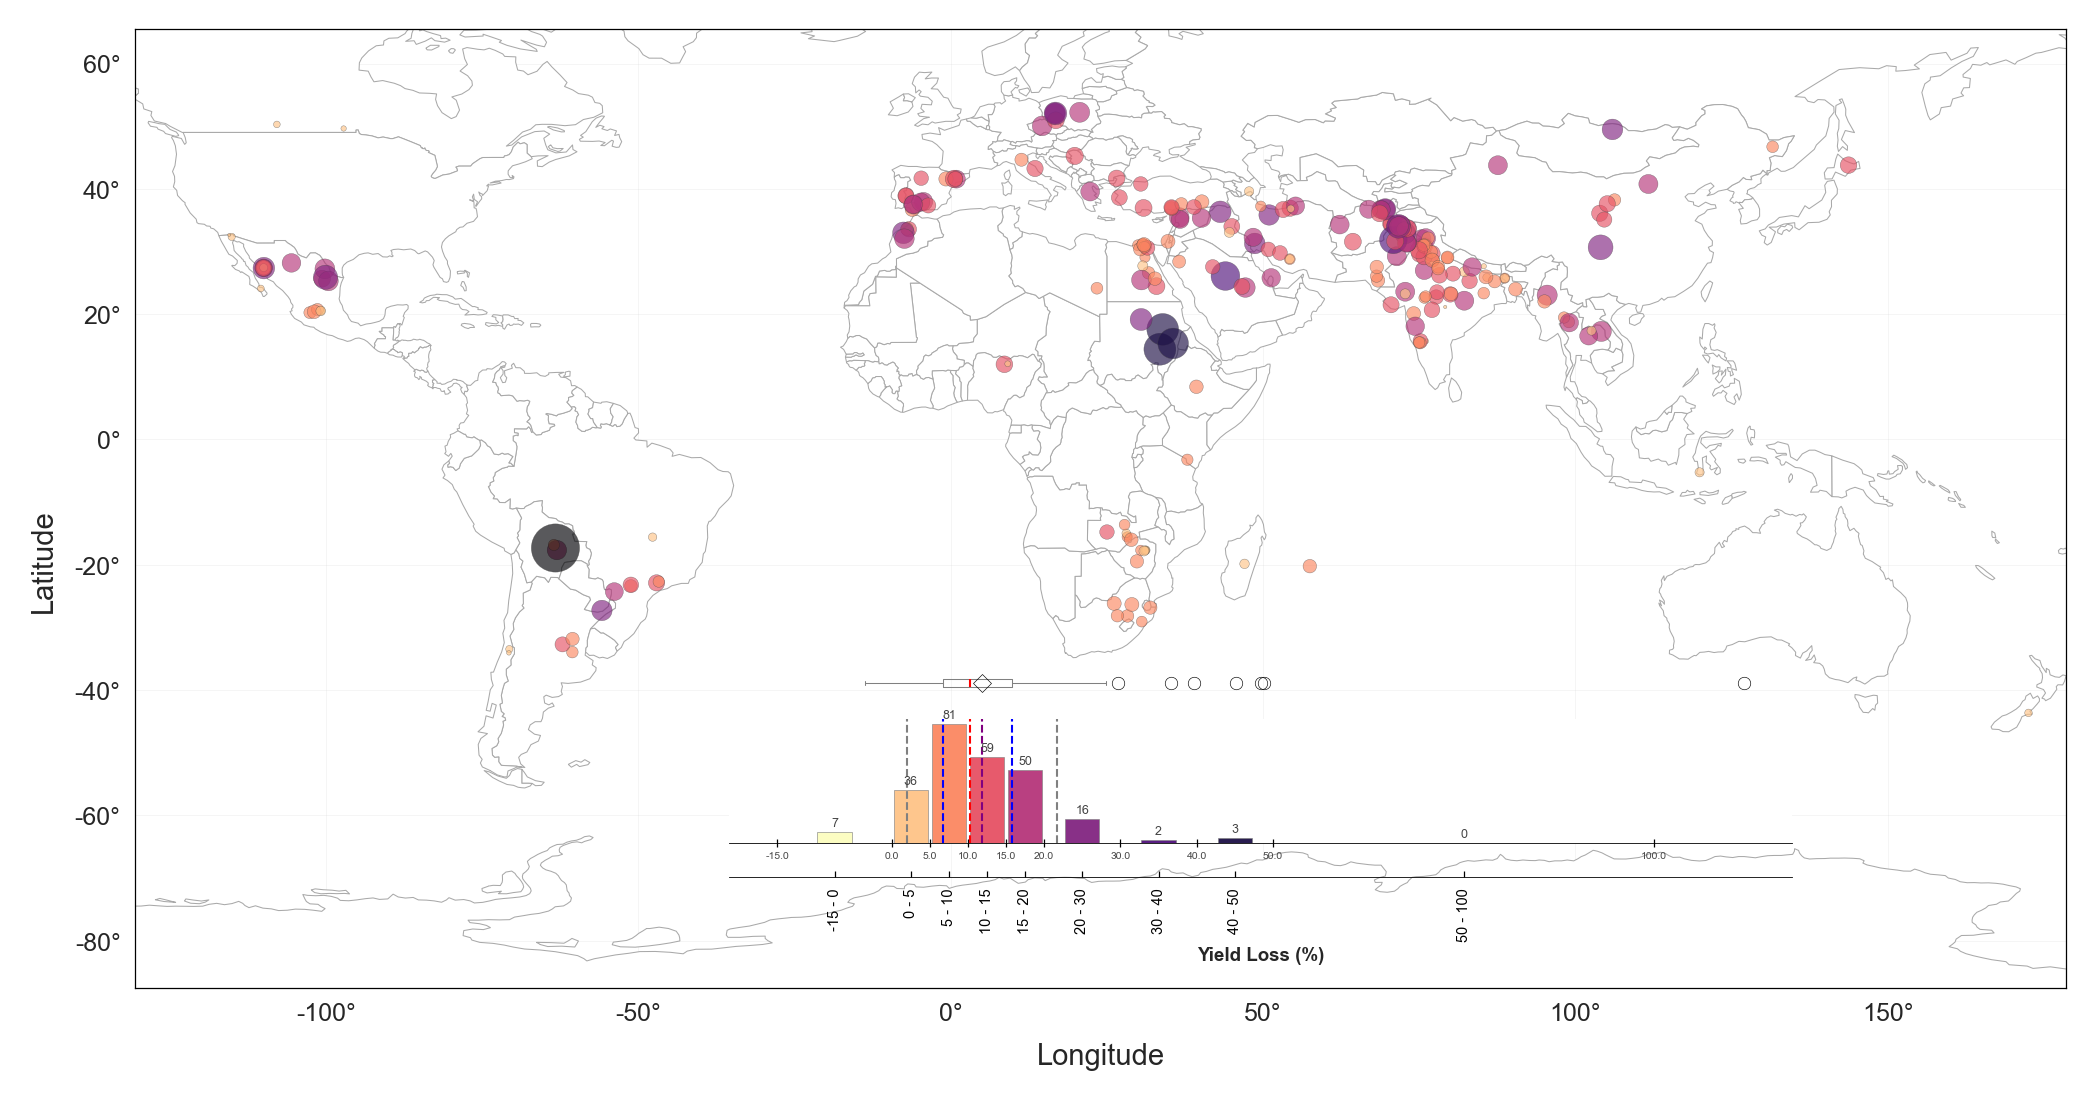

In [15]:
%%time

dispYldLossMap(df_ChangeInTmin_YieldLoss)


### Fig S2. Regression of average TMax, TMin and SolRad during grainfilling vs yield

Supplementary Fig. 2: Prediction of yield at 850 site-years as a function of a) daily average maximum temperature, b) minimum temperature and c) solar radiation observed during the grainfilling period.


CPU times: user 9.89 s, sys: 216 ms, total: 10.1 s
Wall time: 8.79 s


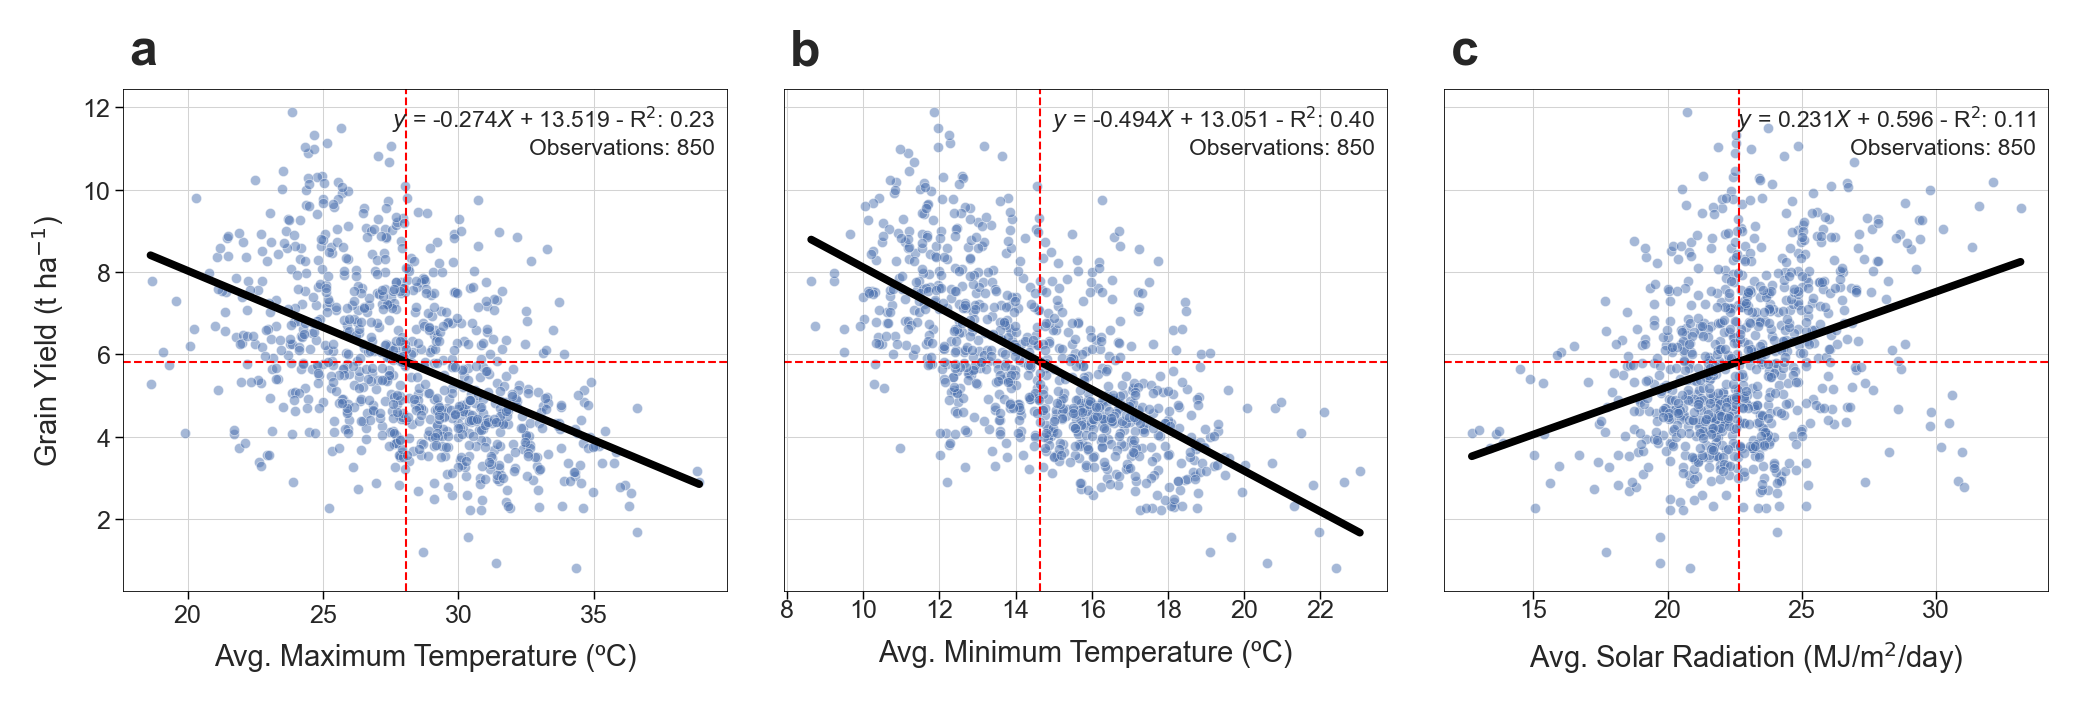

In [16]:
%%time

dispFigS2(gdf_for_Fig1)

### Fig S3. Observed yield at 256 locations

Supplementary Figure 3: Observed average yield at 255 spring wheat nursery test sites.


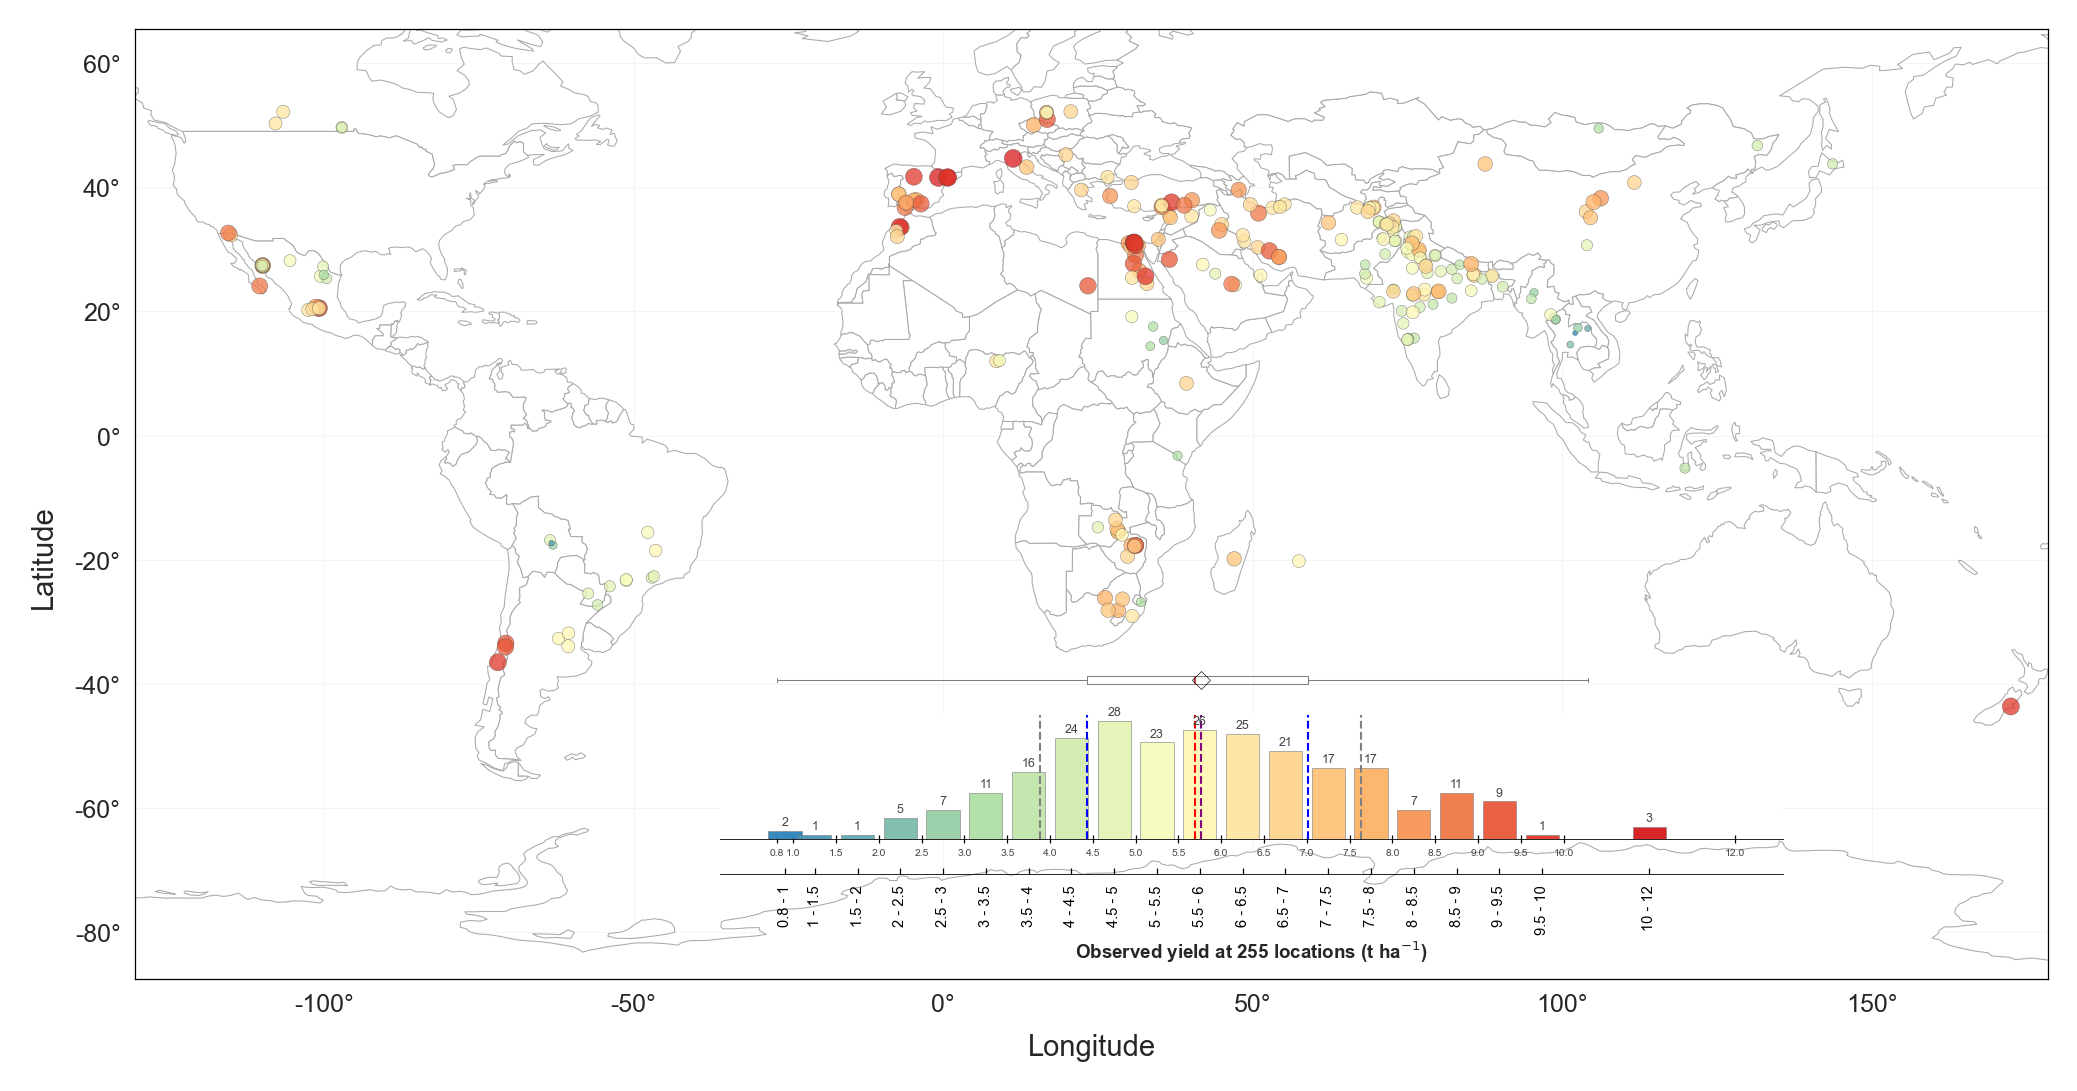

In [17]:
dispLocAveYldMap(df_ChangeInTmin_YieldLoss)

### Fig S4. Duration of grainfilling vs minimum temperature

Supplementary Figure 4: Effect of minimum temperature during grainfilling on the number of reported days between heading and maturity at 262 site-years.

CPU times: user 1.06 s, sys: 74.7 ms, total: 1.14 s
Wall time: 685 ms


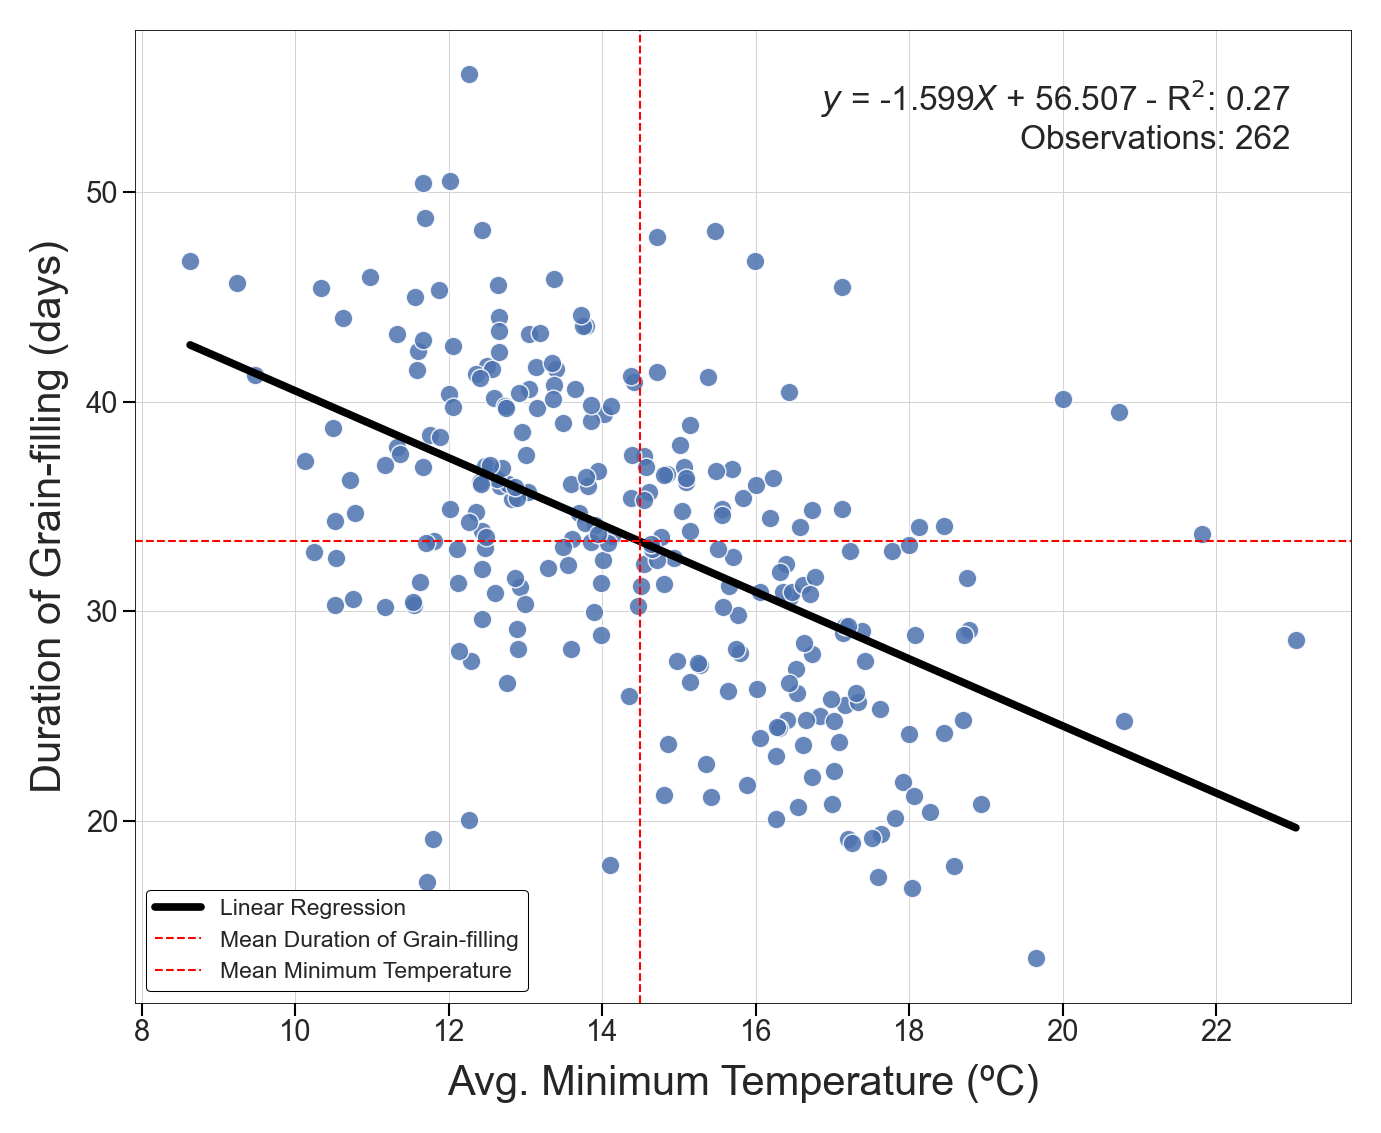

In [18]:
%%time

dispFigS4(gdf_for_Fig1)
        

### Table S1. Importance of variables (850 site years)

Supplementary Fig. 1: Prediction power of environmental variables to estimate grain yield at 850 site-years. Variables represent three periods: 1) sowing to heading minus 10 days (SHMinus10d), 2) heading minus 10 days to heading plus 10 days (HMinus10d-Hplus10d), and 3) heading plus 10 days to maturity (Hplus10dM). The last period represents grain filling. 


In [19]:
%%time
# Load curated IWIN ESWYT dataset for paper
loadTablaofImportantVariables()

CPU times: user 3.08 ms, sys: 1.69 ms, total: 4.77 ms
Wall time: 4.18 ms


Predictor  \
0                    avg_TMin_GrainFill   
1                  avg_SolRad_GrainFill   
2           avg_TMin_Hminus10d-Hplus10d   
3         avg_SolRad_Hminus10d-Hplus10d   
4                   avg_TMin_SHminus10d   
5                   avg_TMax_SHminus10d   
6                    avg_TMax_GrainFill   
7                 avg_SolRad_SHminus10d   
8           avg_TMax_Hminus10d-Hplus10d   
9                    avg_VPD_SHminus10d   
10                 ndays_TMax_Hplus10dM   
11                    avg_VPD_GrainFill   
12  ndays_TMax_gt32C_Hminus10d-Hplus10d   
13          ndays_TMax_gt32C_SHminus10d   
14                 ndays_TMin_Hplus10dM   
15  ndays_VPD_gt4kPa_Hminus10d-Hplus10d   
16          ndays_VPD_gt4kPa_SHminus10d   
17          ndays_TMin_gt25C_SHminus10d   
18  ndays_TMin_gt25C_Hminus10d-Hplus10d   

                                        Variable Name             Period  \
0                       Avg. Minimum Temperature (°C)       Grainfilling   
1                    Avg. Solar Radiation (MJ/m2/day)       Grainfilling   
2                       Avg. Minimum Temperature (°C)            Heading   
3                    Avg. Solar Radiation (MJ/m2/day)            Heading   
4                       Avg. Minimum Temperature (°C)  Sowing to Heading   
5                       Avg. Maximum Temperature (°C)  Sowing to Heading   
6                       Avg. Maximum Temperature (°C)       Grainfilling   
7                    Avg. Solar Radiation (MJ/m2/day)  Sowing to Heading   
8                       Avg. Maximum Temperature (°C)            Heading   
9                   Avg. Vapor Pressure Deficit (kPa)  Sowing to Heading   
10     Number of days Avg. Maximum Temperature > 32°C       Grainfilling   
11                  Avg. Vapor Pressure Deficit (kPa)       Grainfilling   
12     Number of days Avg. Maximum Temperature > 32°C            Heading   
13     Number of days Avg. Maximum Temperature > 32°C  Sowing to Heading   
14                      Avg. Minimum Temperature (°C)       Grainfilling   
15  Number of days Avg. Vapor Pressure Deficit > 4...            Heading   
16  Number of days Avg. Vapor Pressure Deficit > 4...  Sowing to Heading   
17     Number of days Avg. Minimum Temperature > 25°C  Sowing to Heading   
18     Number of days Avg. Minimum Temperature > 25°C            Heading   

    Contribution  Portion  Rank  
0        715.670   0.4120     1  
1        278.766   0.1605     2  
2        194.766   0.1121     3  
3         97.847   0.0563     4  
4         95.936   0.0552     5  
5         60.174   0.0346     6  
6         57.860   0.0333     7  
7         48.787   0.0281     8  
8         48.604   0.0280     9  
9         43.096   0.0248    10  
10        39.738   0.0229    11  
11        31.111   0.0179    12  
12        19.749   0.0114    13  
13         4.675   0.0027    14  
14         0.430   0.0002    15  
15         0.048   0.0000    16  
16         0.000   0.0000    17  
17         0.000   0.0000    18  
18         0.000   0.0000    19

<img src="./data/Table_S1.png" width=780 height=400 />